
Training: Logistic Regression


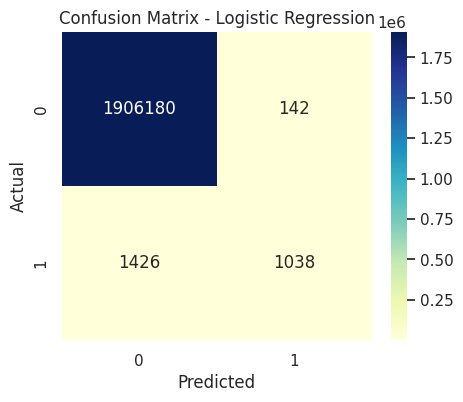


Training: Random Forest


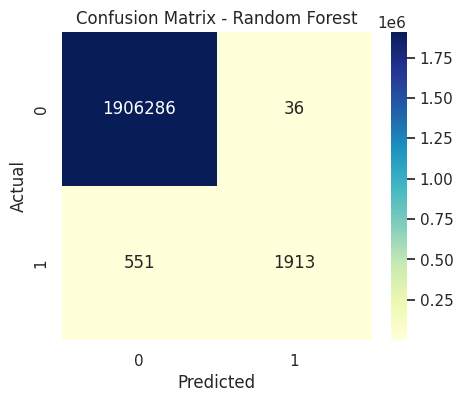


Training: XGBoost


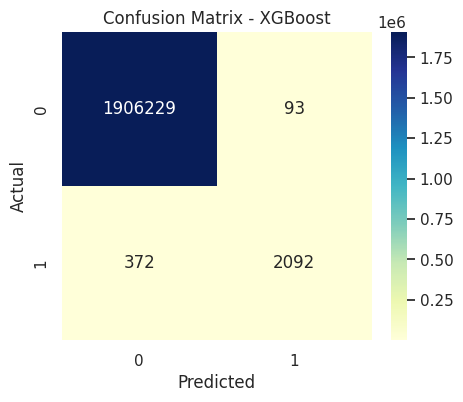

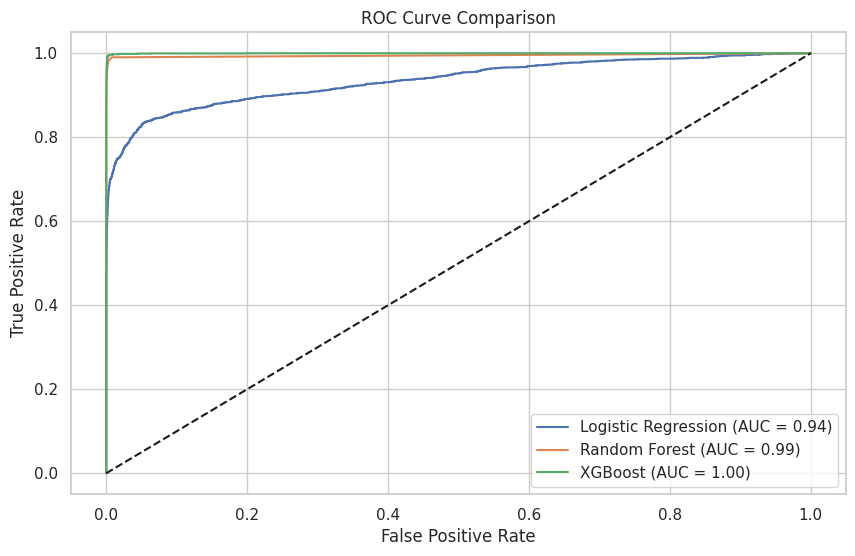

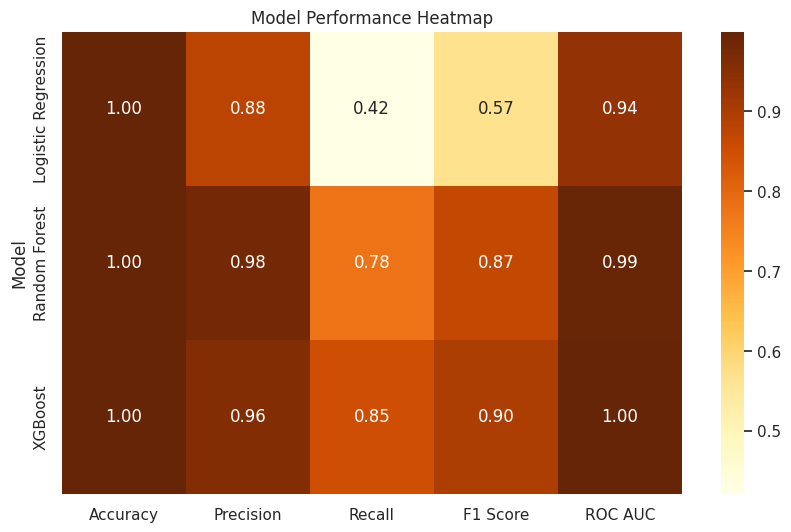

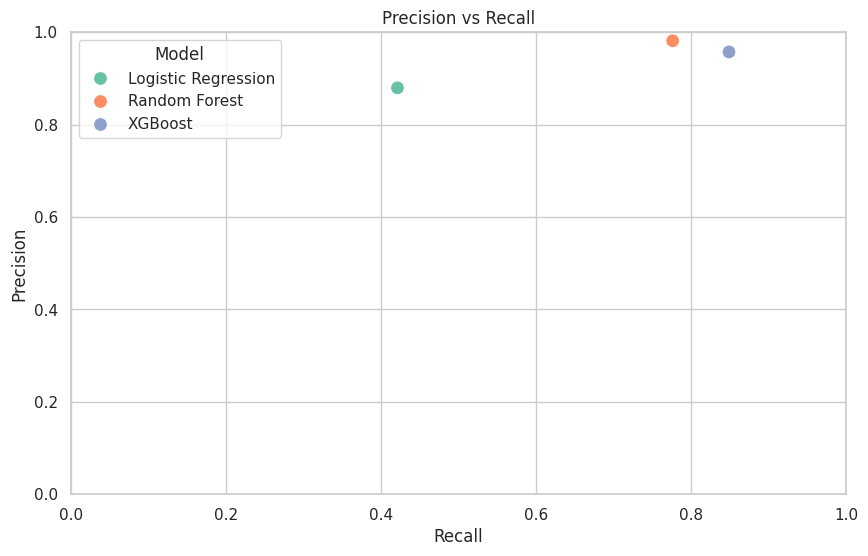

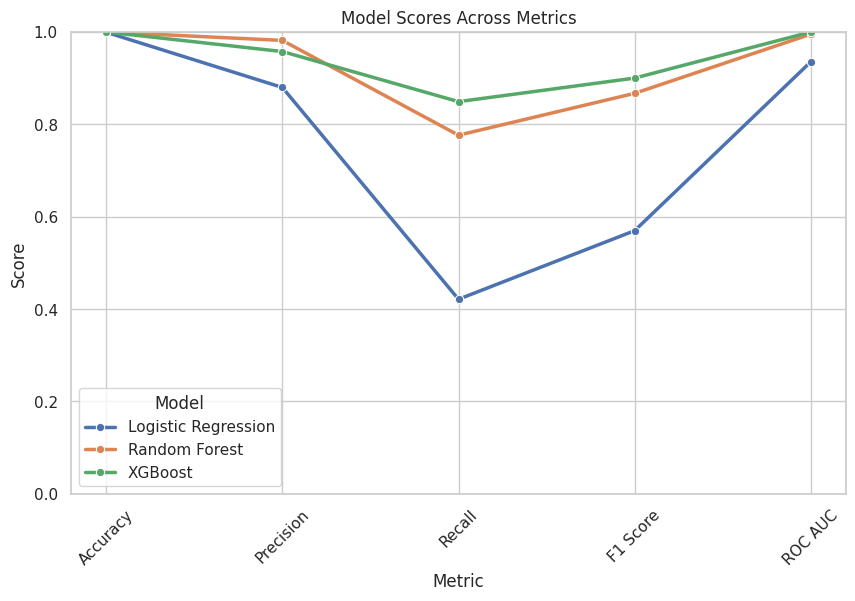

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

zip_path = '/content/onlinefraud.csv.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

csv_path = '/content/onlinefraud.csv'
df = pd.read_csv(csv_path)

df['type'] = LabelEncoder().fit_transform(df['type'])
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

X = df.drop('isFraud', axis=1)
y = df['isFraud']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
roc_curves = {}

for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': auc
    })

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_curves[name] = (fpr, tpr, auc)

plt.figure(figsize=(10,6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results)

plt.figure(figsize=(10,6))
sns.heatmap(results_df.set_index('Model'), annot=True, fmt=".2f", cmap="YlOrBr")
plt.title('Model Performance Heatmap')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=results_df, x='Recall', y='Precision', hue='Model', s=100, palette='Set2')
plt.title('Precision vs Recall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=results_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
             x='Metric', y='Score', hue='Model', marker='o', linewidth=2.5)
plt.title('Model Scores Across Metrics')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()